In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'


In [3]:
os.getcwd()

'/Users/jeongjaewon/Desktop/1조'

# Load Data

In [4]:
sample=pd.read_csv('./data/Ckdpharm.csv', encoding='cp949')
sample['이름']='종근당'

In [15]:
sample.head()

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,이름,scale_종가
0,2021/05/18,131500,2500,1.94,130000,132000,128500,49799,6489836500,1502532018500,11426099,종근당,0.248125
1,2021/05/17,129000,-1500,-1.15,130500,131500,129000,49203,6379045000,1473966771000,11426099,종근당,0.185675
2,2021/05/14,130500,1500,1.16,129500,130500,128500,45614,5922424000,1491105919500,11426099,종근당,0.223145
3,2021/05/13,129000,-2000,-1.53,128500,131000,128000,61750,7977100500,1473966771000,11426099,종근당,0.185675
4,2021/05/12,131000,-3000,-2.24,133000,134000,130000,62434,8240556000,1496818969000,11426099,종근당,0.235635


# Preprocessing
- <주가의 일자>와 <키워드의 publish> 날짜 값을 일치 시킴

In [16]:
keyword = pd.read_csv('./keyword/vaccine_data.csv')

keyword['publish'] = keyword['publish'].apply(lambda row: re.sub(r'\.','/',row[:-1]))

In [17]:
keyword.head()

,publish,vacc_mention,size,adj_vacc,period
0,2020/08/15,99,1485,0.066667,period_2
1,2020/08/16,2,1386,0.001443,period_2
2,2020/08/17,1,1881,0.000532,period_2
3,2020/08/19,1,990,0.001010,period_2
4,2020/08/25,688,1485,0.463300,period_2


### 1. keyword data

In [18]:
keyword['adj_vacc'].describe()
#키워드 언급율

count    32.000000
mean      0.152863
std       0.150180
min       0.000505
25%       0.003577
50%       0.122759
75%       0.228430
max       0.526441
Name: adj_vacc, dtype: float64

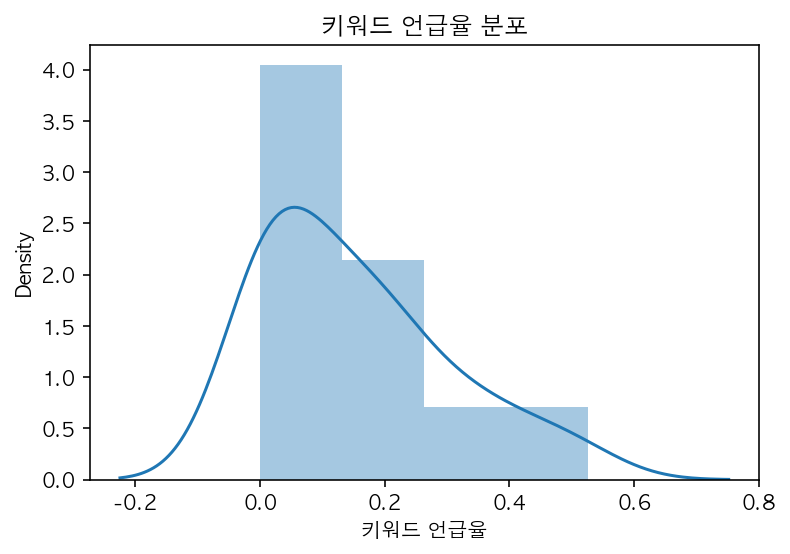

In [19]:
sns.distplot(keyword['adj_vacc'])
plt.xlabel('키워드 언급율')
plt.title('키워드 언급율 분포')
plt.show()

In [20]:
# 키워드 언급율 변수의 scale이 주가와 큰 차이가 난다 (0~1사이 값이므로)
# 특히 분포를 보면 0에 매우 근접하였음을 알 수 있다

### 2. 주식 데이터
- 각 주식별로 StandardScaler 돌린다
- 전체에 대해서 돌리지 않아야함 -> 전체에 대해서 적용하면 각 주식의 고유한 분포를 망가뜨릴 수 있기 때문에

In [21]:
!pip install sklearn

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sample[['scale_종가']]=scaler.fit_transform(sample[['종가']])
#scale_종가 = 종가를 minmax scaling한 값

In [23]:
data2 = pd.merge(sample[['일자','종가', 'scale_종가']], keyword[['publish','adj_vacc']],  
                 right_on = 'publish', left_on='일자', how='right').drop('일자', axis=1)
data2 = data2.rename({'publish':'일자'}, axis=1)
data2 = data2.fillna(method='bfill') 
#주식 시장이 쉬는날에는 주가데이터가 존재하지 않음 ->이 경우 발생하는 nan값은 나중값으로 채움(backfill)

In [24]:
data2= data2.sort_values('일자')

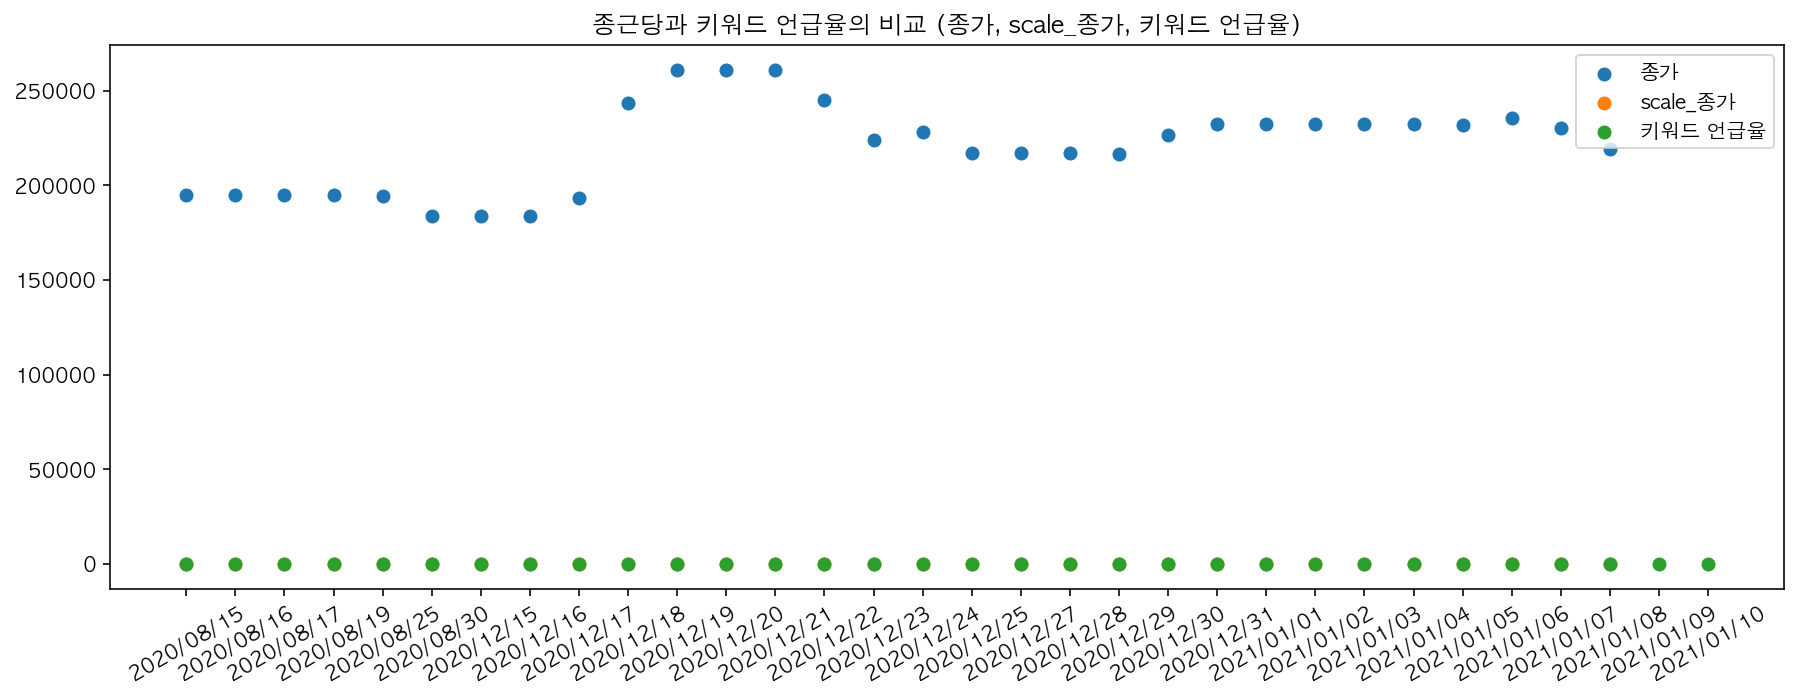

In [25]:
plt.subplots(figsize=(15,5))
plt.scatter(x='일자',y ='종가',data=data2)
plt.scatter(x='일자',y ='scale_종가',data=data2)
plt.scatter(x='일자',y ='adj_vacc',data=data2, label = '키워드 언급율')
plt.xticks(rotation=30)
plt.legend()
plt.title('종근당과 키워드 언급율의 비교 (종가, scale_종가, 키워드 언급율)')
plt.show()
# 세 개를 plotting했음에도 scale_종가가 보이지 않음
# 또한 adj_vacc(키워드 언급율)이 0-1사이의 값이라서 스케일이 큰 종가 변수와 같이 plotting했을 때, adj_vacc변수는 값의 차이를 알아 볼 수 없다
# 따라서 종가 변수를 제외하고 plotting을 다시 실행해본다

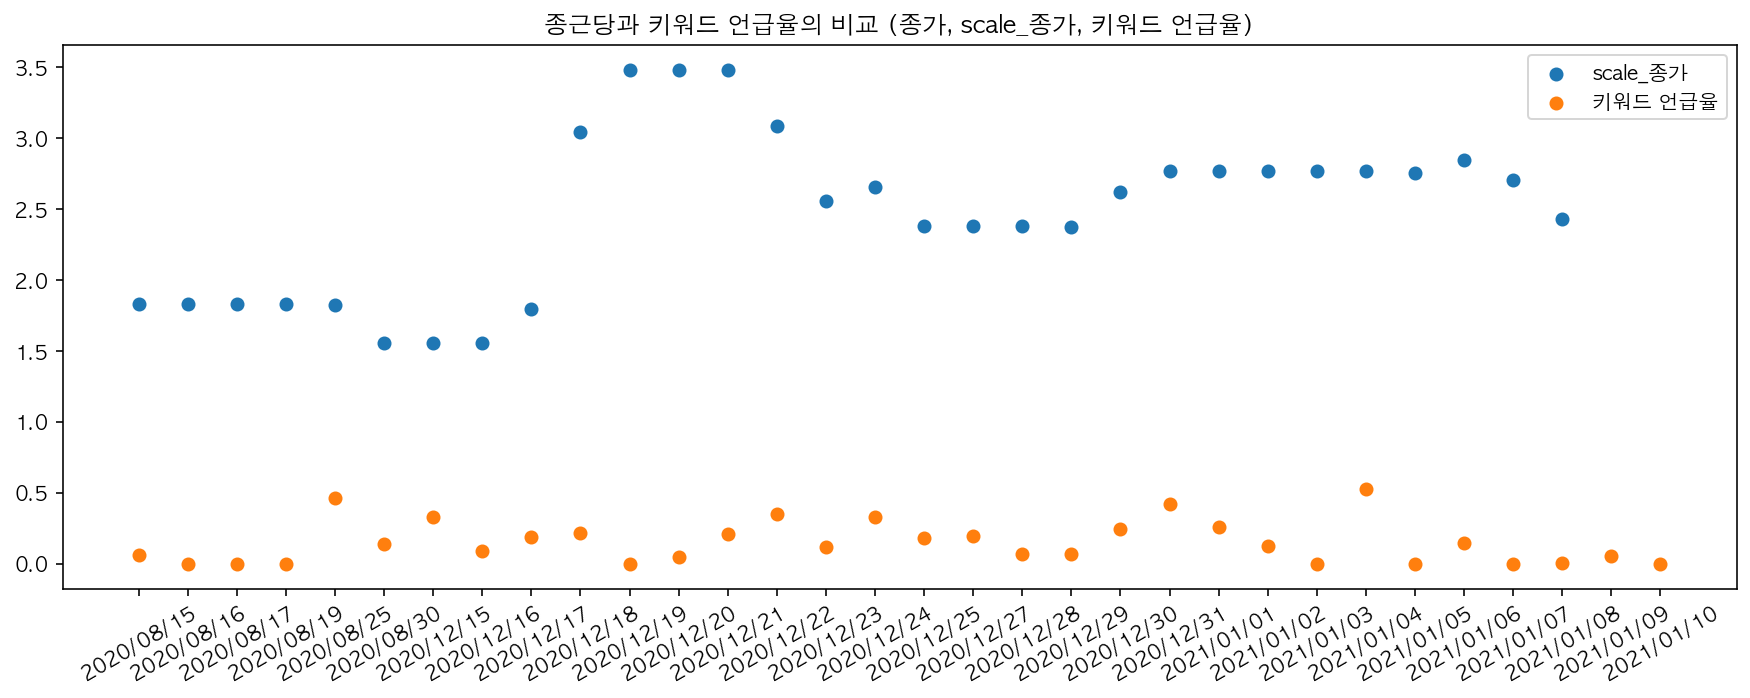

In [26]:
plt.subplots(figsize=(15,5))
#plt.scatter(x='일자',y ='종가',data=data2)
plt.scatter(x='일자',y ='scale_종가',data=data2)
plt.scatter(x='일자',y ='adj_vacc',data=data2, label = '키워드 언급율')
plt.xticks(rotation=30)
plt.legend()
plt.title('종근당과 키워드 언급율의 비교 (종가, scale_종가, 키워드 언급율)')
plt.show()
#scale_종가와 adj_vacc(키워드 언급율) 간의 스케일이 비슷해서 증감 추이를 같이 확인해 볼 수 있다

- plot을 보고 'scale_종가'와 'adj_vacc'를 변수로 선택함

# Correlation

corr: 0.05389922017498241


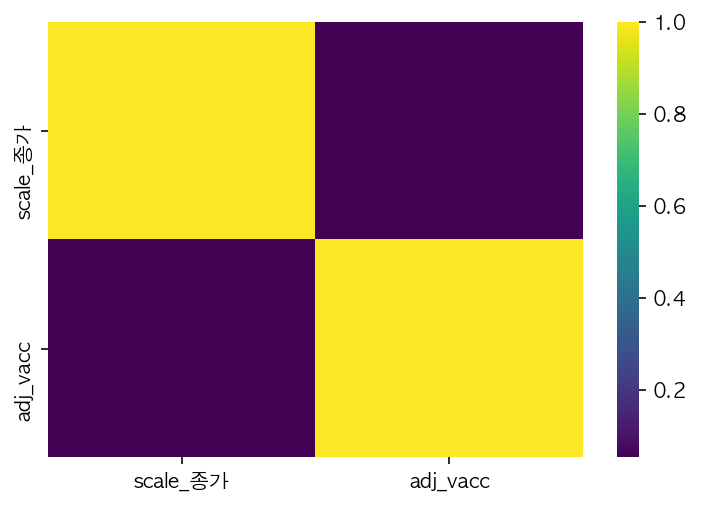

In [27]:
#종근당의 scale_종가와 키워드 언급율에 대해 상관관계를 조사해보았다
corr = data2[['scale_종가','adj_vacc']].corr()
print('corr:',np.array(corr)[0,1])
sns.heatmap(corr, cmap = 'viridis')
plt.show()

In [28]:
corr

,scale_종가,adj_vacc
scale_종가,1.000000,0.053899
adj_vacc,0.053899,1.000000


# 전체 데이터에 적용
- 이전까지 종근당 데이터에 대해서만 적용하였으므로, 이제부터는 전체 주가데이터에 대해서 적용하도록 한다

In [29]:
def scaler_func(df):
    scaler = StandardScaler()
    stock_group = df[['종가']]
    scaled = scaler.fit_transform(stock_group) #각 주식 그룹에 대해 fit_tranform시킴
    return scaled

In [59]:
file_dir='./data'
company=['젠큐릭스','종근당','셀리드','셀트리온','삼성바이오로직스','제넥신','바이오니아','진원생명과학','씨젠','대웅','피씨엘','유바이오로직스']
total_df = pd.DataFrame()
i=0
for file_name in os.listdir('./data'):
    if file_name.endswith('csv') and file_name != 'owid-covid-data.csv':
        print(file_name)
        df = pd.read_csv(os.path.join(file_dir,file_name), encoding = 'cp949')
        df['이름'] = company[i]
        scaled_array = scaler_func(df)
        df['scale_종가'] = scaled_array
        total_df = pd.concat([total_df,df])
        i+=1 

Gencurix.csv
Ckdpharm.csv
Cellid.csv
Celltrion.csv
Samsung_BioLogics.csv
Genexine.csv
Bioneer.csv
Genels.csv
Seegene.csv
Daewoong.csv
Pclchip.csv
Eubiologics.csv


In [62]:
total_df=total_df[['이름','일자', '종가', 'scale_종가','대비', '등락률', '시가', '고가', '저가', '거래량', '거래대금', '시가총액',
       '상장주식수']]

In [63]:
category = {"mRNA" :['삼성바이오로직스'], "kit" : ['씨젠','바이오니아','젠큐릭스','피씨엘'],
            "vacc" : ['진원생명과학','제넥신','유바이오로직스','셀리드'], "tre" : ['종근당','셀트리온','대웅']}

def categorize(row):
    '''
    각 주식이 어떤 분야에 해당하는지 분류하는 함수
    '''
    for key,values in category.items():
        if row in category[key]:
            return key
        
total_df['분야'] = total_df['이름'].apply(lambda row: categorize(row))

In [64]:
total_df.head()

,이름,일자,종가,scale_종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,분야
0,젠큐릭스,2021/05/18,21950,0.773029,250,1.15,21800,22100,21250,62618,1352238100,141951484100,6467038,kit
1,젠큐릭스,2021/05/17,21700,0.707258,-750,-3.34,22500,22600,21450,89390,1959916250,140334724600,6467038,kit
2,젠큐릭스,2021/05/14,22450,0.904572,150,0.67,22500,22650,21700,75327,1671565450,145185003100,6467038,kit
3,젠큐릭스,2021/05/13,22300,0.865109,-1050,-4.50,22650,23650,21950,120638,2741481300,144214947400,6467038,kit
4,젠큐릭스,2021/05/12,23350,1.141348,-350,-1.48,23550,24100,22450,220544,5156506500,151005337300,6467038,kit


In [65]:
df2 = pd.merge(total_df[['분야','이름','일자', 'scale_종가']], keyword[['publish','adj_vacc']],  
                 right_on = 'publish', left_on='일자', how='right').drop('일자', axis=1)
df2 = df2.rename({'publish':'일자'}, axis=1)
df2 = df2.fillna(method='bfill') 
#주식 시장이 쉬는날에는 주가데이터가 존재하지 않음 ->이 경우 발생하는 nan값은 나중값으로 채움(backfill)

In [66]:
df2 = df2.sort_values(['분야','이름'])

In [67]:
df2.head()

,분야,이름,scale_종가,일자,adj_vacc
9,kit,바이오니아,2.709590,2020/08/19,0.001010
21,kit,바이오니아,2.587349,2020/08/25,0.463300
34,kit,바이오니아,0.975294,2020/12/15,0.332211
46,kit,바이오니아,0.990575,2020/12/16,0.090909
58,kit,바이오니아,0.944734,2020/12/17,0.187500


## "백신" 키워드 언급율과 주가 변동 plot하기

첫번째 주기 [2020-03-03 ~ 2020-03-10]
두번째 주기 [2020-08-15 ~ 2020-09-02]
세번째 주기 [2020-12-15 ~ 2021-01-10]

**2차에 해당하는 데이터 포인트가 적어서 함께 그렸습니다**

In [68]:
df2= df2.sort_values('일자')

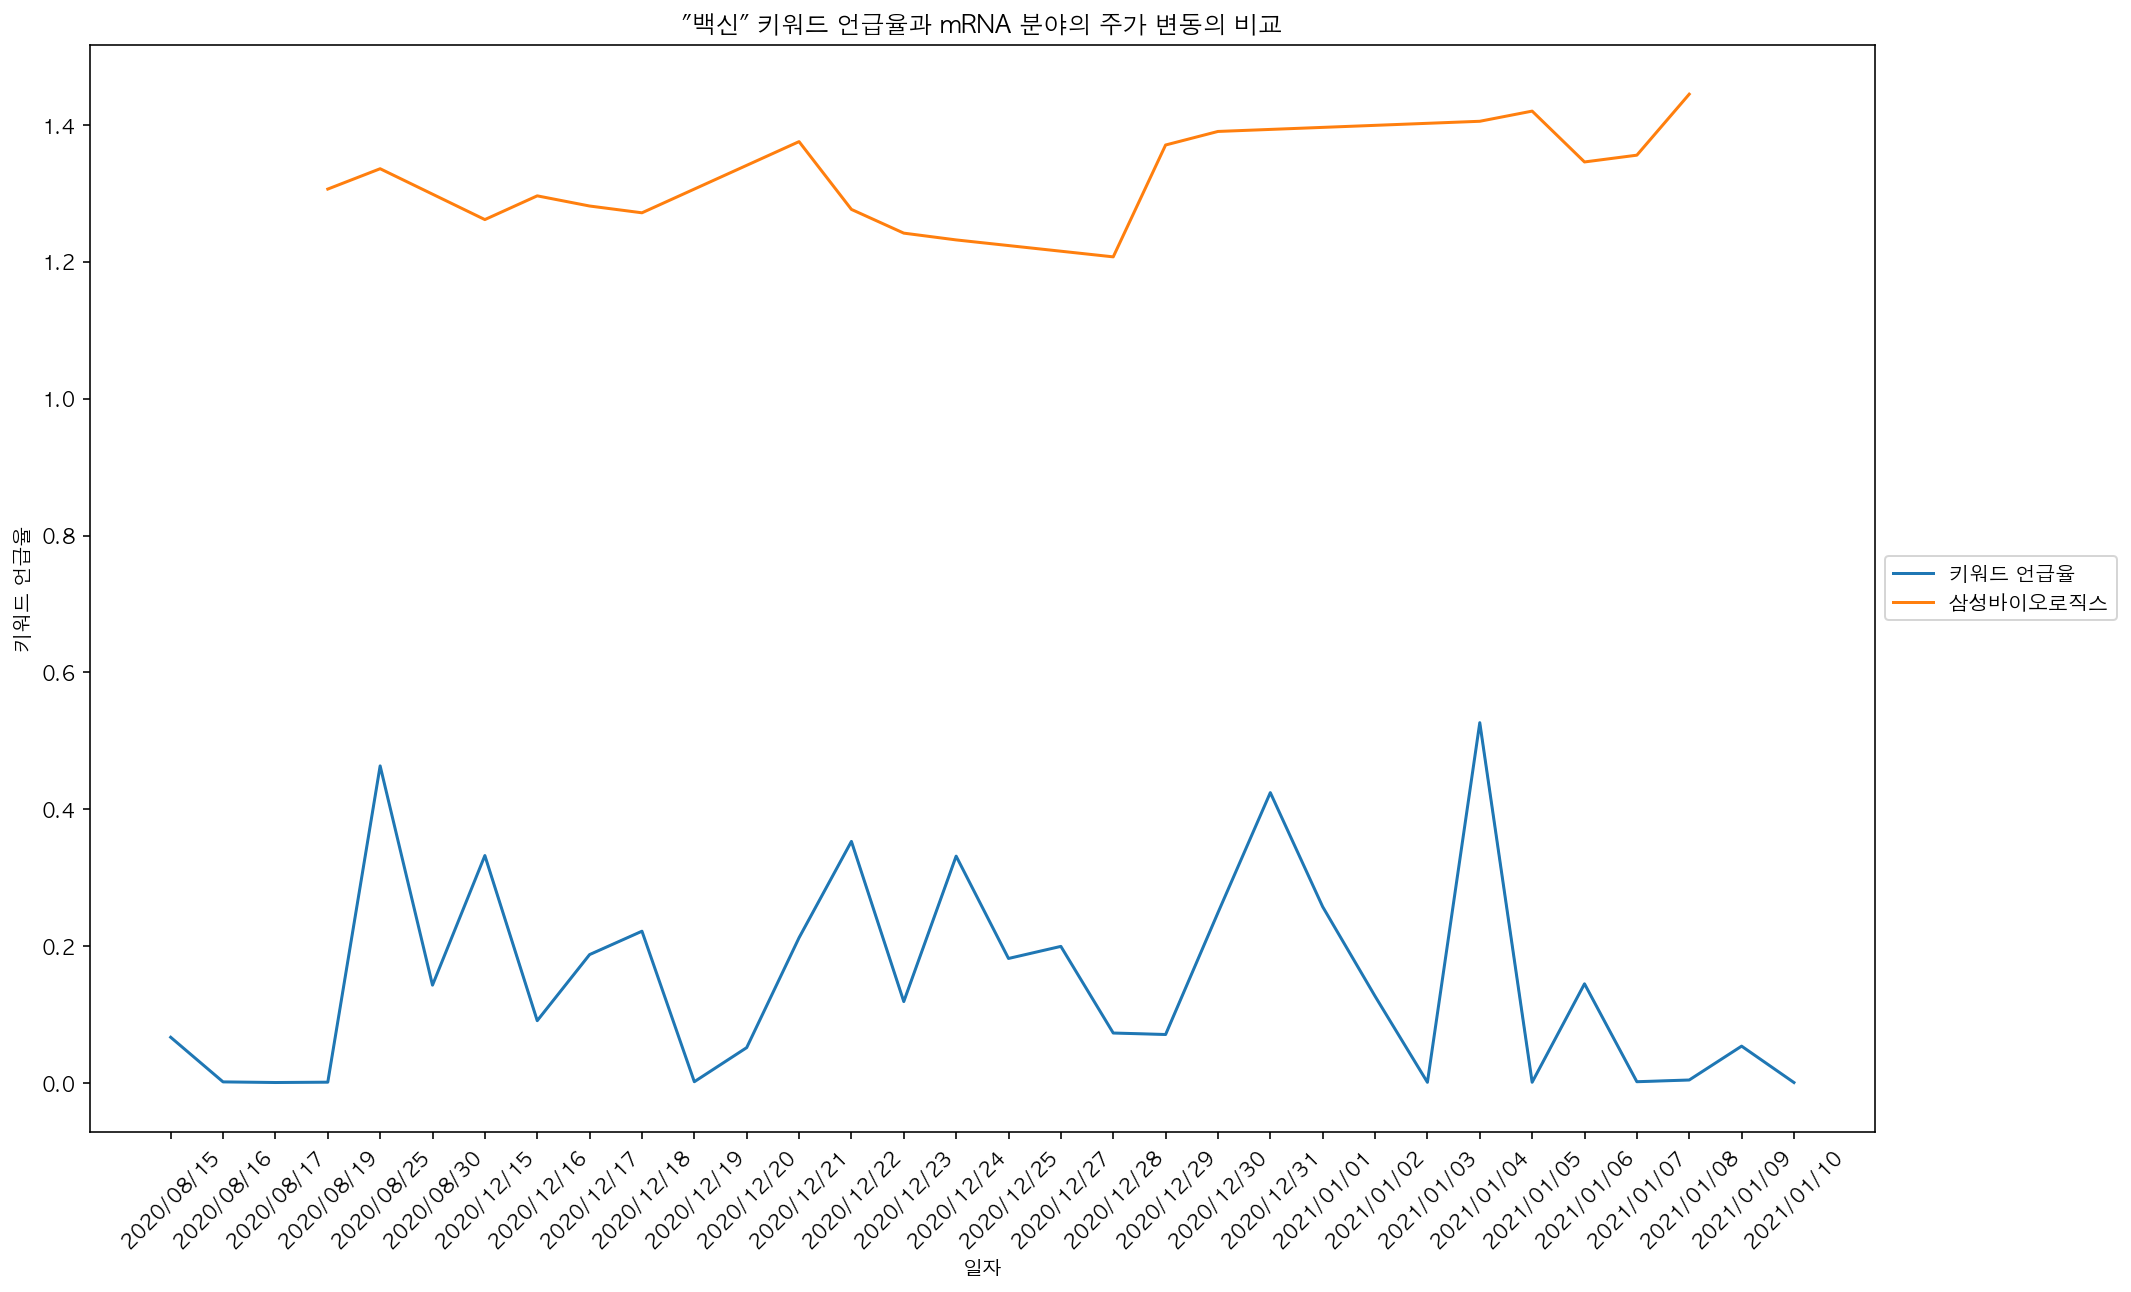

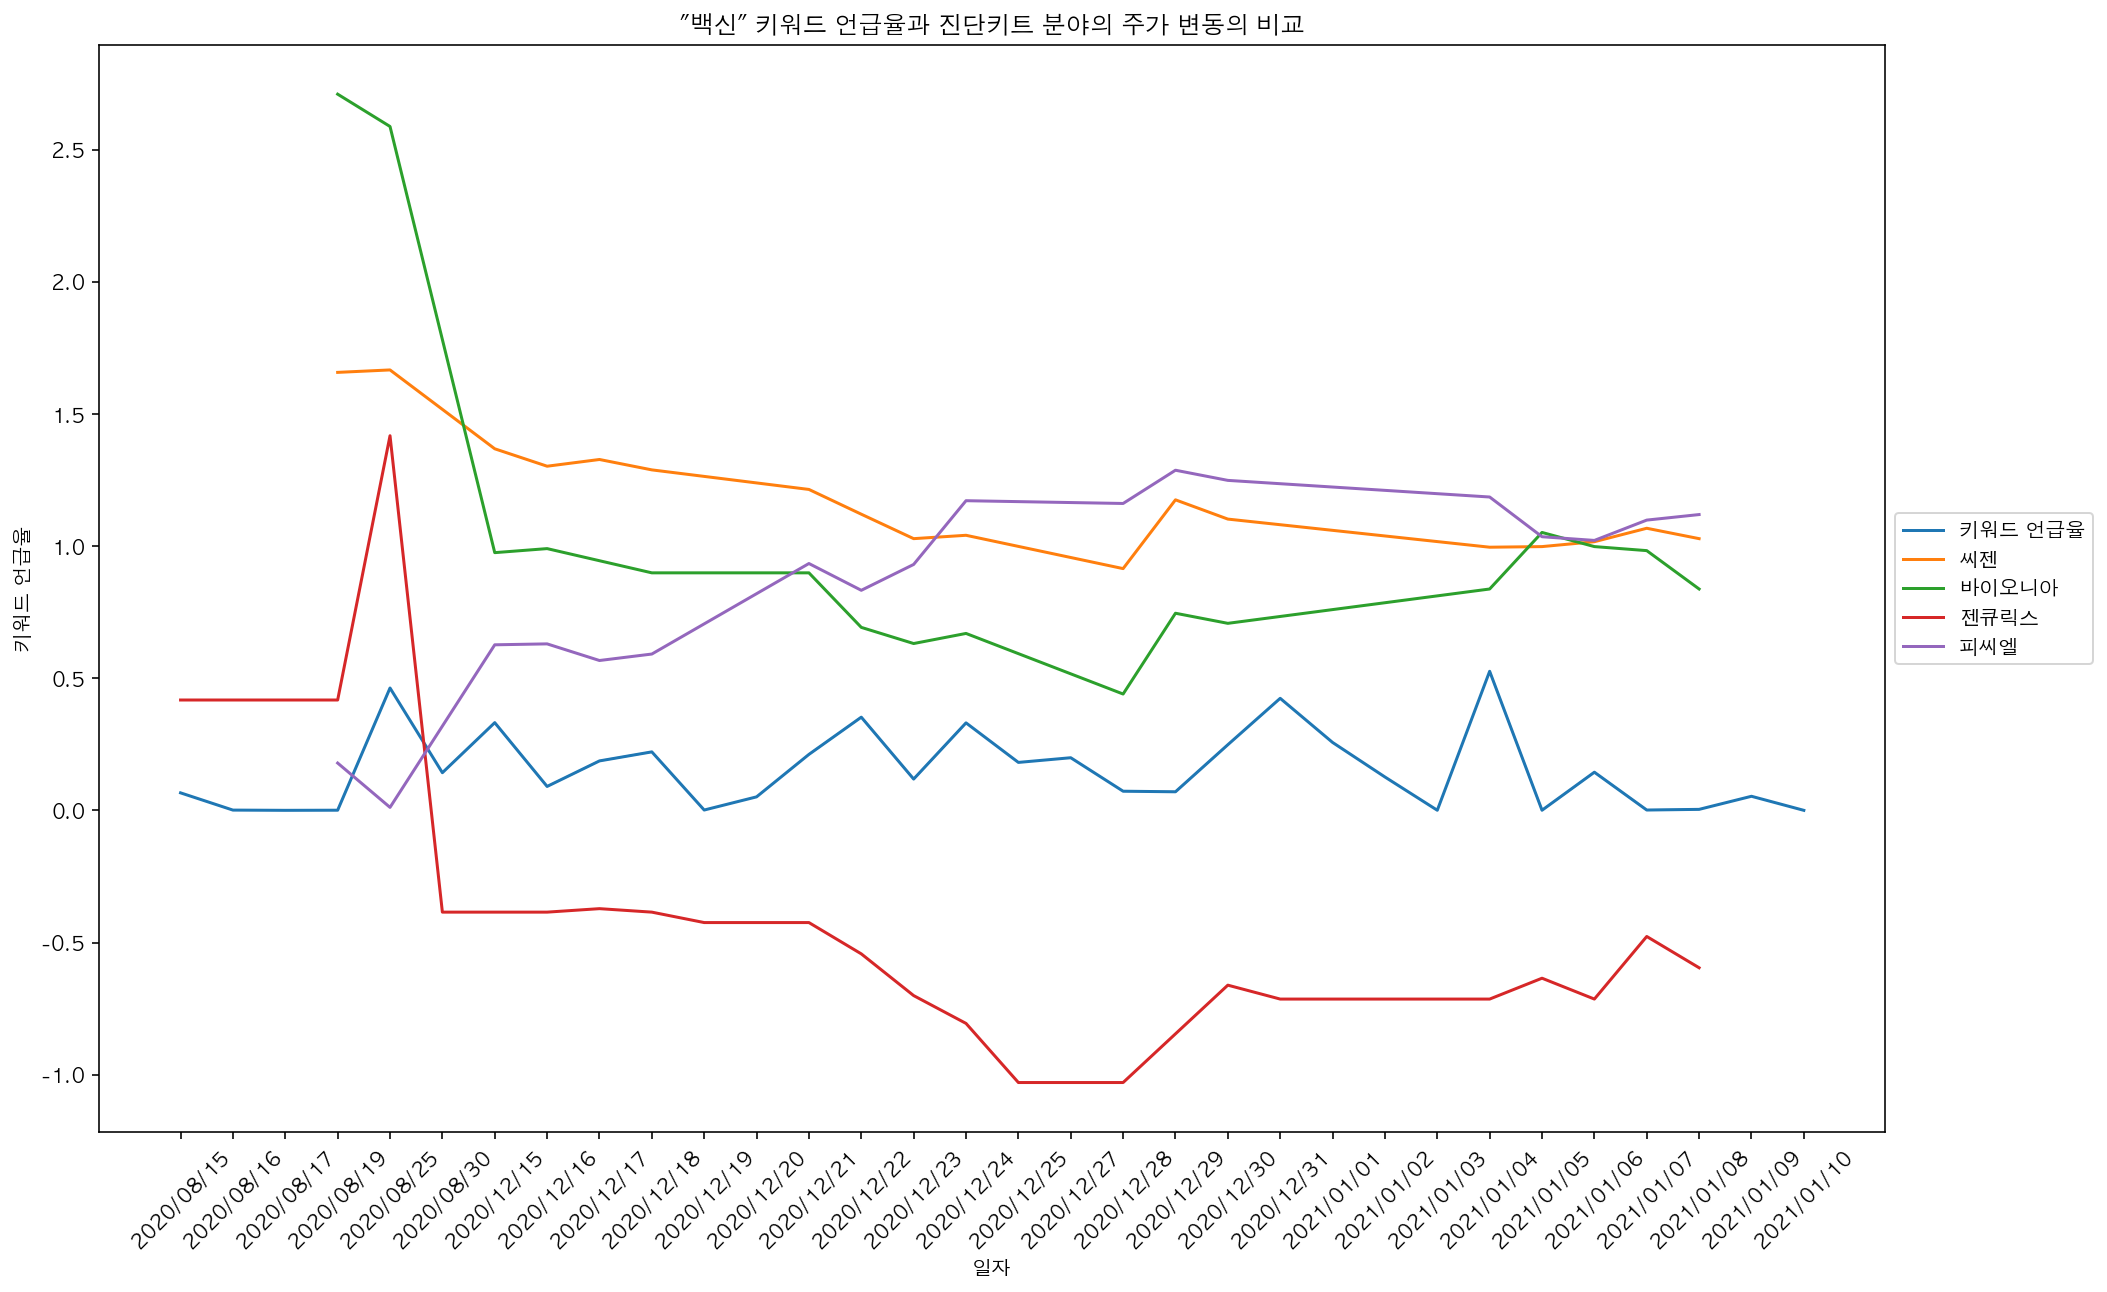

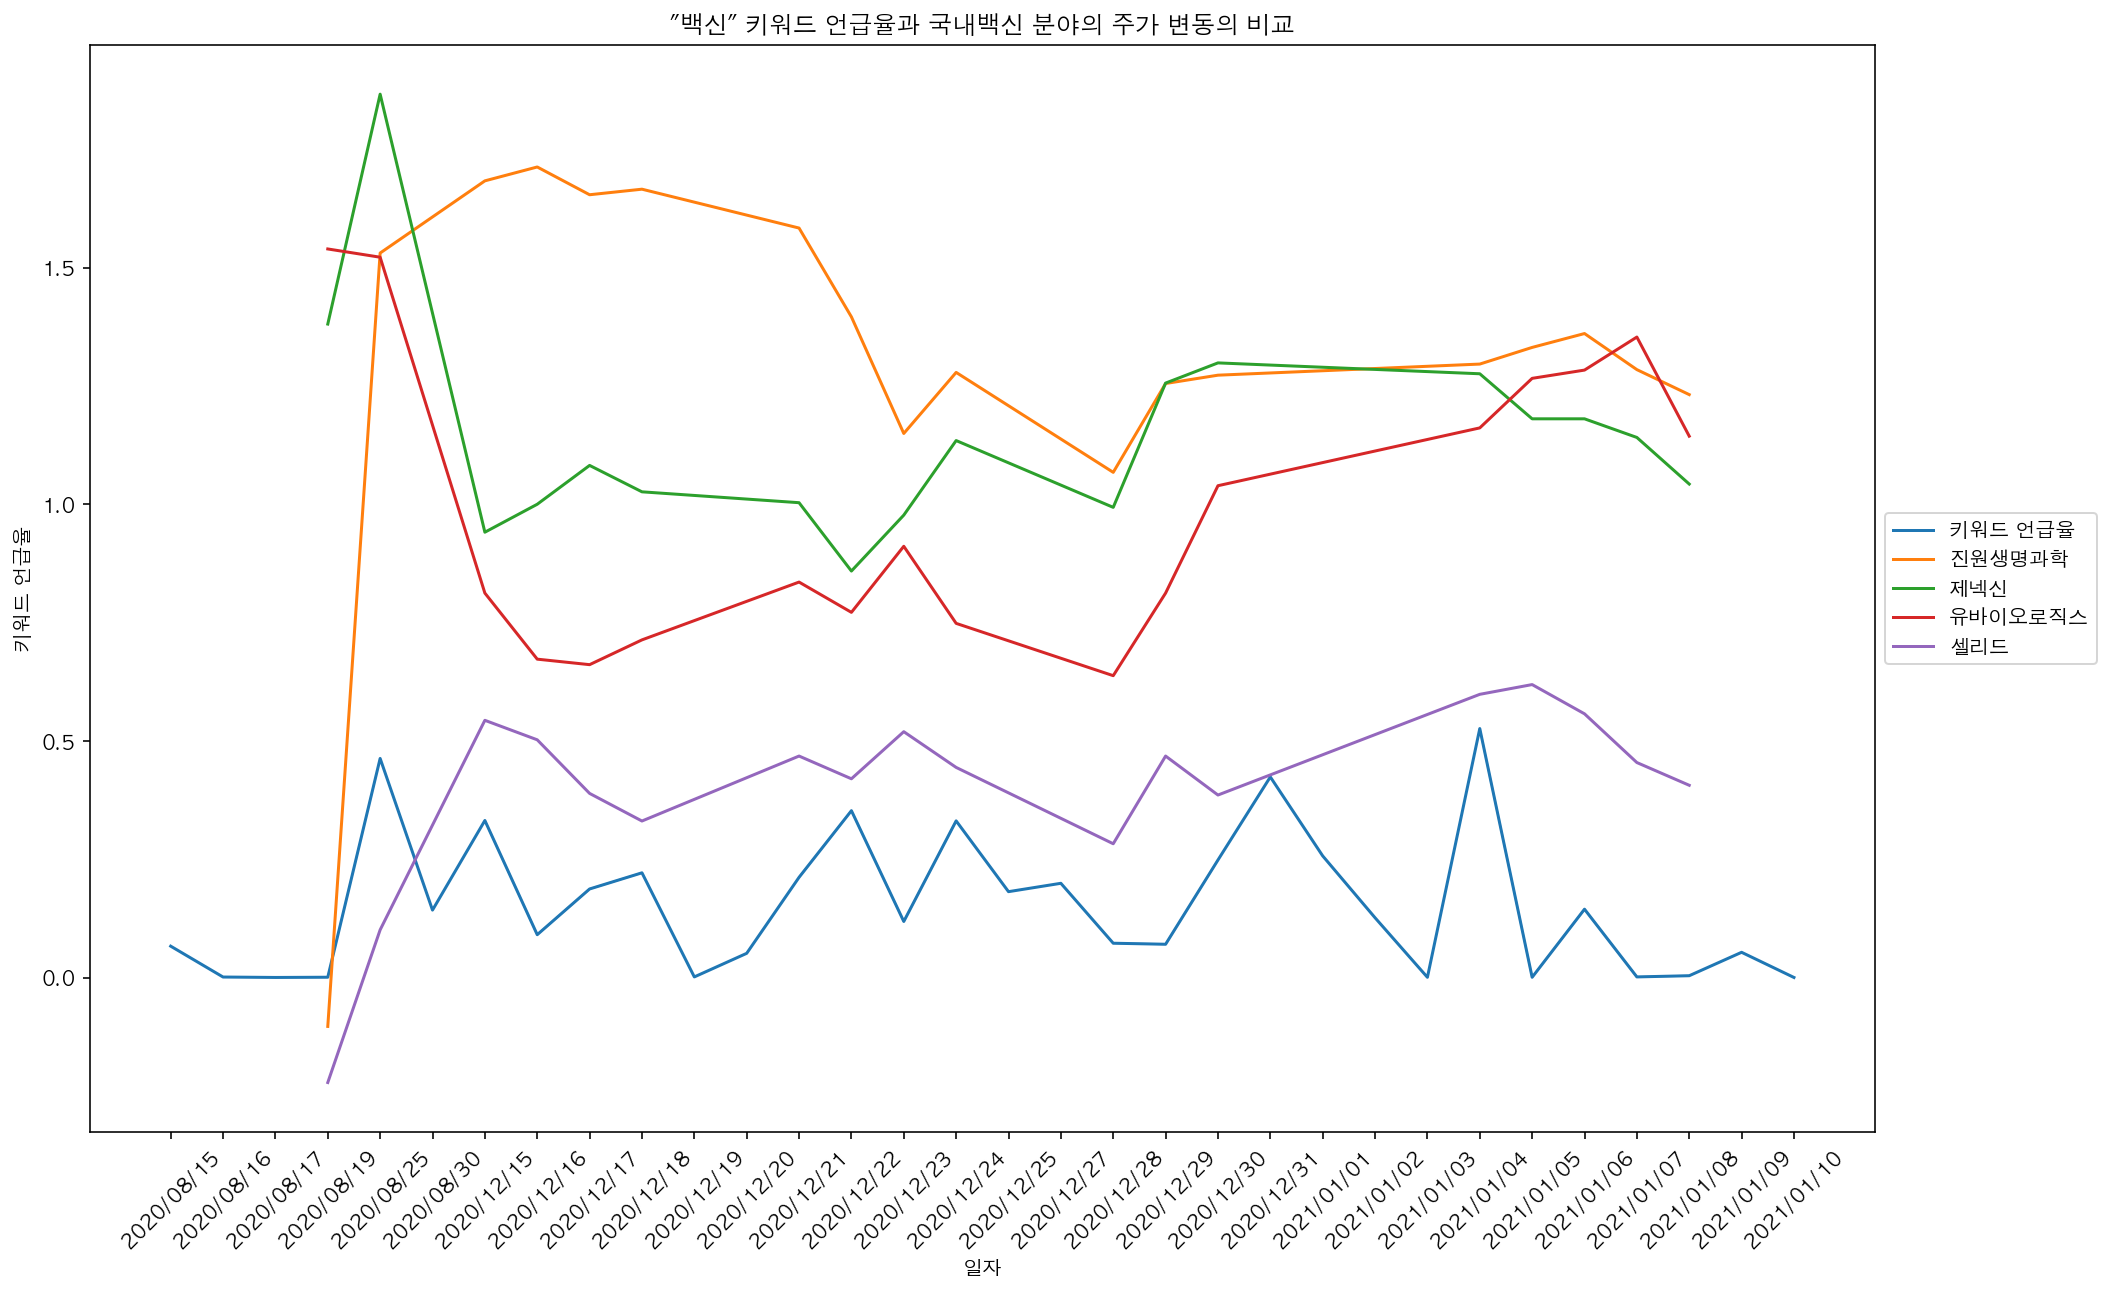

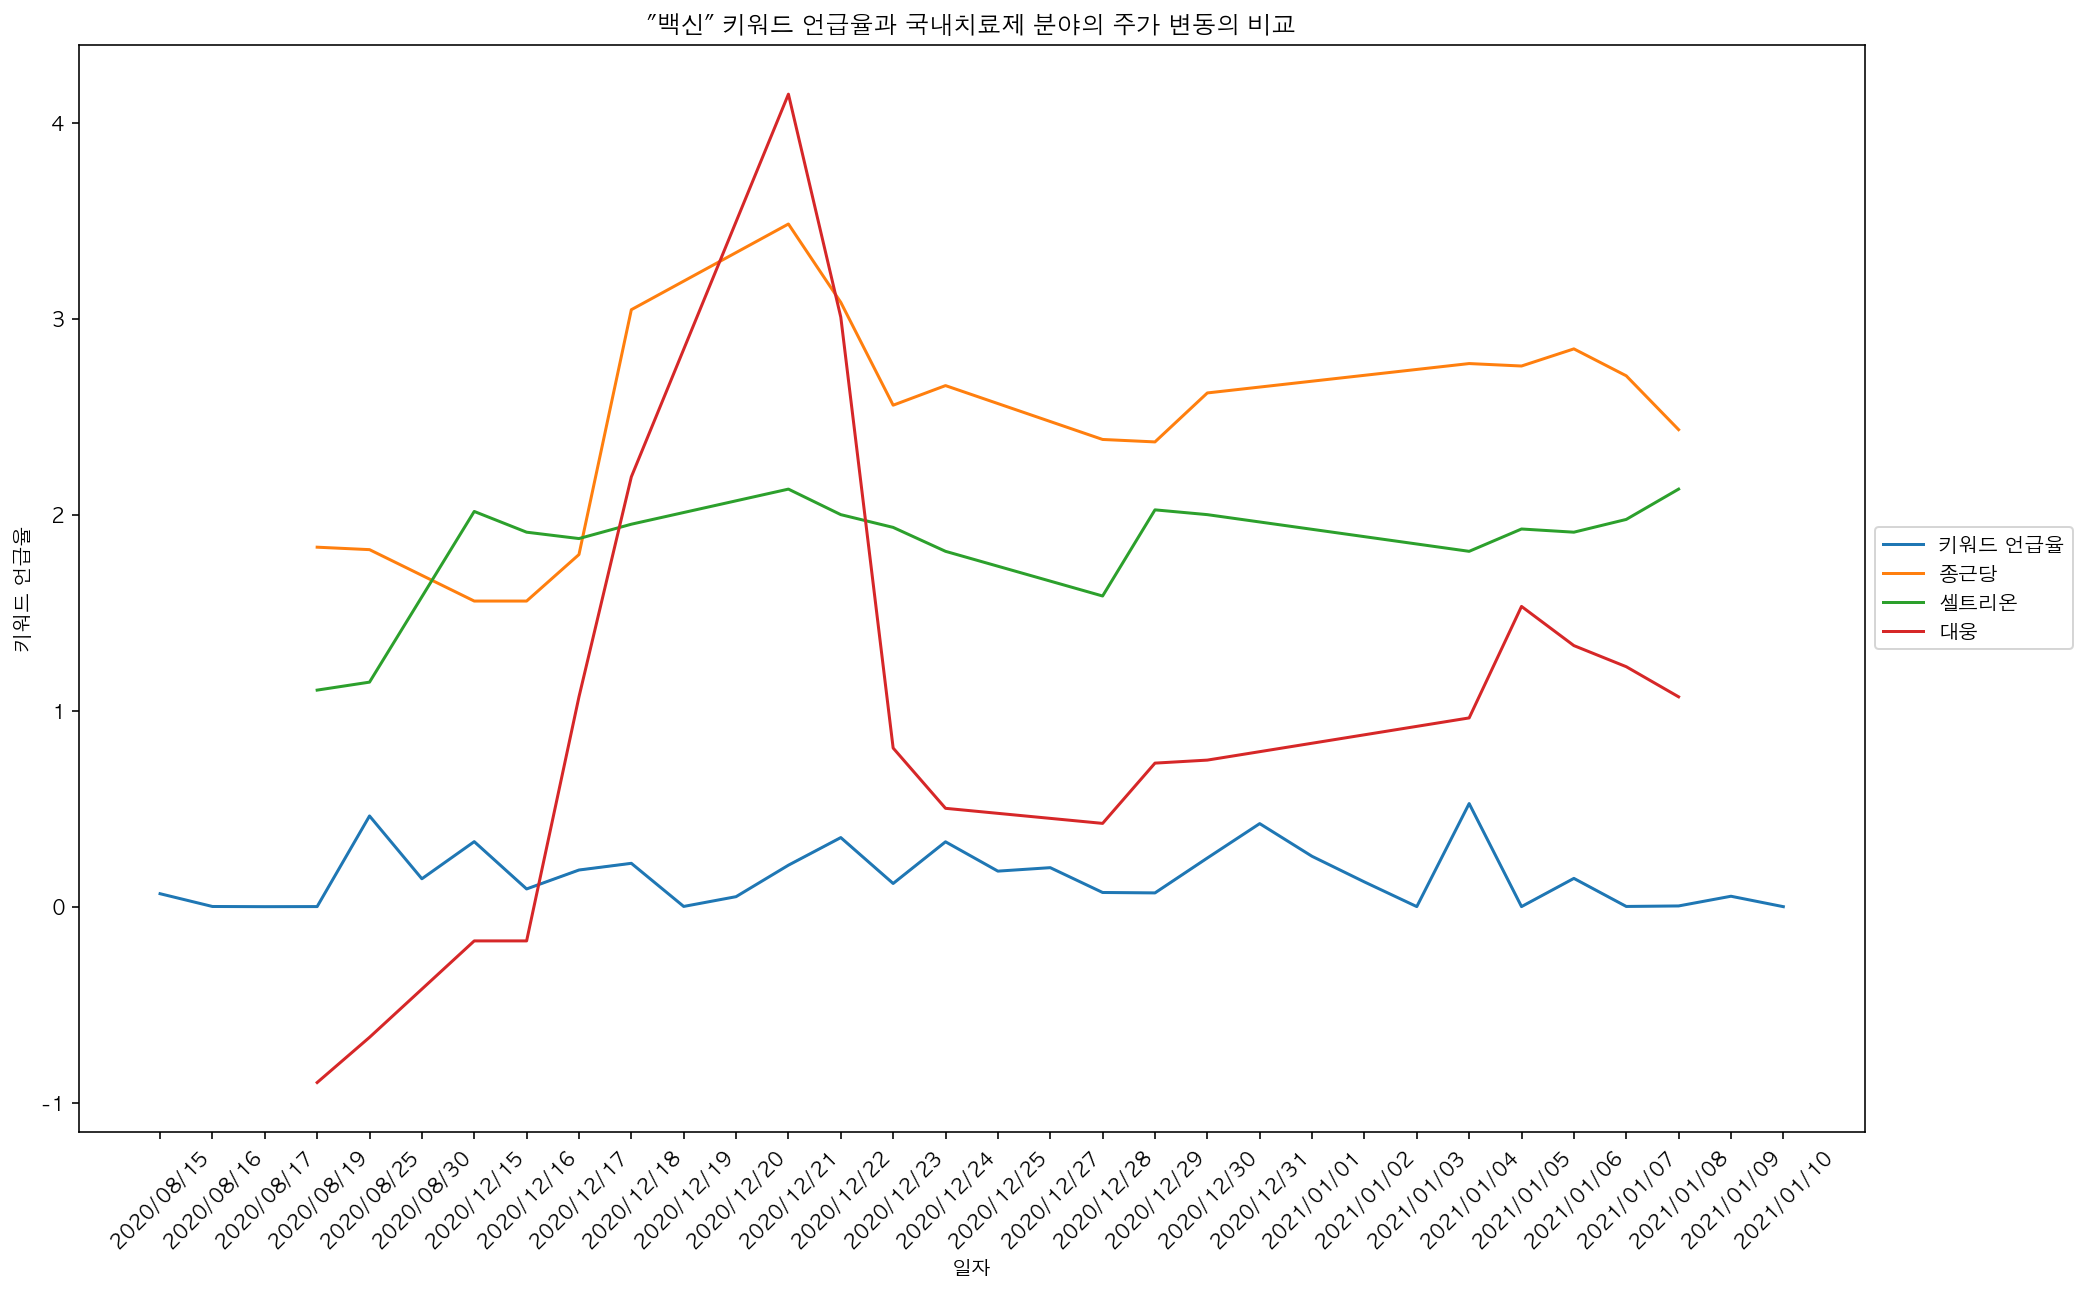

In [69]:
title_name = ['mRNA','진단키트','국내백신','국내치료제']
for i, (cat, stocks) in enumerate(category.items()):
    plt.subplots(figsize = (16,10))
    sns.lineplot(x ='일자', y='adj_vacc', data=df2, label='키워드 언급율')
    d=df2[df2['분야']==cat]
    for stock_name in stocks:
        sns.lineplot(x ='일자', y='scale_종가', data=d[d['이름']==stock_name], label=f'{stock_name}')
    plt.xticks(rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('키워드 언급율')
    plt.title(f'"백신" 키워드 언급율과 {title_name[i]} 분야의 주가 변동의 비교')
plt.show()

1) mRNA 분야의 경우, 

- 삼바 주식 하나밖에 없기 때문에  비교 대상이 없음
- 키워드와 삼바의 상관계수는 -0.1207

2) 진단키트 분야:

- 씨젠, 바이오니아, 젠큐릭스 3개의 주가 그래프가 유사한 기울기를 가지며 다소 하락함
- 오히려 피씨엘의 경우 상승함
- 그러나 4개의 주가 모두 2-3차를 거쳐 점진적으로 하락하는 경향을 보임
- 젠큐릭스가 급격하게 하락

3) 국내 백신 분야:

- 2차 대유행때는 4개의 주가가 다른 양상을 보임
    - 제넥신과 셀리드, 진원생명과학은 소폭 상승
    - 유바이오로직스는 소폭 하락
    - 특히, 진원은 3등으로 시작했으나, 2차 대유행을 거쳐 주가가 4개중 1-2등이 되었음
    - 그에 반해 유바이오는 1등으로 시작했으나  2차 대유행을 거쳐 주가가 4개중 3-4등이 됨
- 전반적으로 2,3차에 거쳐 4개의 주가가 모두 상승함 (이는 국내 치료제에서도 찾아볼 수 있음) → 미디어에서 "백신" 키워드에 대해 자주 노출됨에 따라, 국내 백신 제조 기업과 치료제 기업에 대한 미래 가치의 기대가 상승하였다고 추론할 수 있음

4) 국내 치료제 분야

- 3개 주식 모두 상승세임
- 대웅의 경우 3차 대유행 초기에 급격하게 상승하였으나, 3차 대유행 중간 부터 주가가 급락함.
    - 당시에는 12월 첫째 주 즈음 영국등에서 처음으로 백신 접종을 한 사람이 생겨나기 시작했으나, 안전성에 대한 우려와 국내 물량 확보의 불확실성으로 치료제에 대한 주가가 상승한 것으로 보임
    - 그러나 영국발 변이바이러스 가 12월 22일 즈음에 국내 유입됨에 따라 치료제에 대한 신뢰도가 떨어진 것으로 보임

## 키워드 언급율과 주가간의 상관관계 구하기
- 이때의 주가는 minmaxscale 된 값임
- 상관계수는 scaling 여부와 관계없으므로, scale_종가와 키워드 언급율간의 상관관계를 조사함

In [70]:
total_corr = df2.groupby(['분야','이름'])['scale_종가','adj_vacc'].corr()

In [71]:
corr_vals = total_corr.reset_index()['scale_종가']
indexer = np.array([i for i in range(len(corr_vals)) if i%2==1])
corr_vals = corr_vals[indexer]
corr_vals.name = 'corr'
corr_vals = corr_vals.reset_index(drop=True)

corr_df = total_corr.reset_index()[['분야','이름']].drop_duplicates().reset_index(drop=True)
corr_df = pd.concat([corr_df, corr_vals], axis=1)

In [72]:
corr_df

,분야,이름,corr
0,kit,바이오니아,0.048485
1,kit,씨젠,0.165888
2,kit,젠큐릭스,-0.017437
3,kit,피씨엘,-0.171287
4,mRNA,삼성바이오로직스,-0.120761
5,tre,대웅,0.038590
6,tre,셀트리온,-0.122784
7,tre,종근당,0.058382
8,vacc,셀리드,0.106561
9,vacc,유바이오로직스,-0.080933


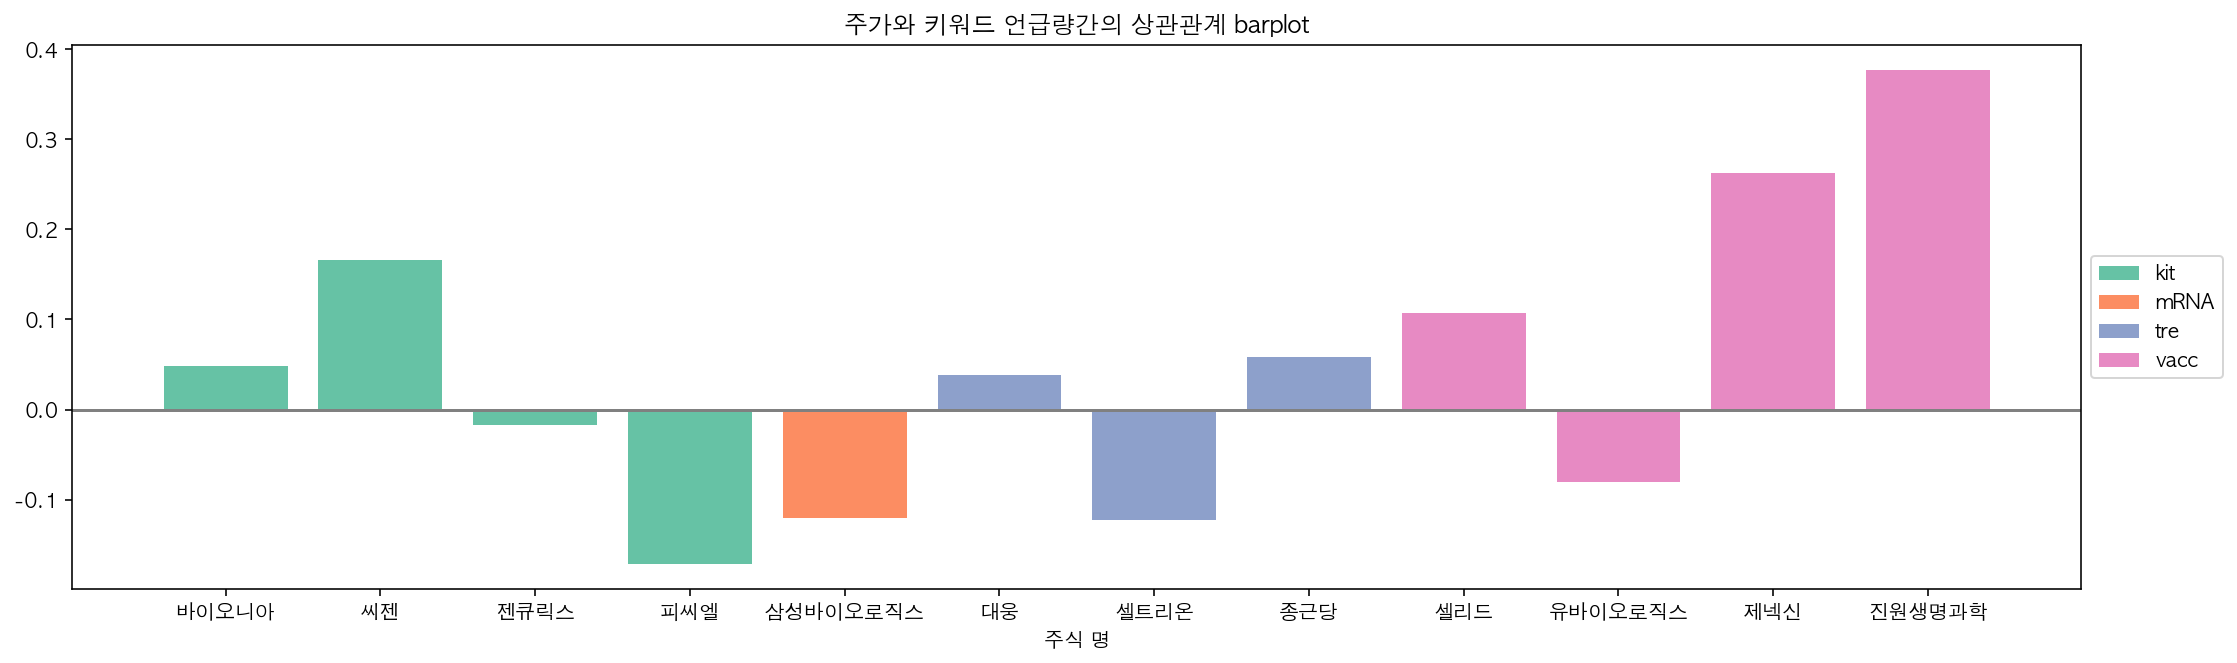

In [73]:
labels = corr_df['분야'].unique()
cmap = sns.color_palette('Set2',4) 
colors={}
[colors.update({n:c}) for c,n in zip(cmap, labels)]

plt.subplots(figsize=(18,5))
ax = plt.subplot(111)

plt.bar(corr_df['이름'], corr_df['corr'], color= corr_df['분야'].map(colors)) #Plot data on subplot axis

for i, j in colors.items(): #Loop over color dictionary
    ax.bar(corr_df['이름'], corr_df['corr'],width=0,color=j,label=i) #Plot invisible bar graph but have the legends specified

plt.axhline(y=0, color='gray', linestyle='-')

plt.title('주가와 키워드 언급량간의 상관관계 barplot')
plt.xlabel('주식 명')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


- 키워드 언급율과 가장 큰 상관관계를 가지는 주식은 제넥신과 진원(둘다 국내 백신주) -> 예상 가능한 결과 였음
- 삼바의 경우 워낙 높은 곳에서 가격이 형성되어있고, 주가 변동이 크지 않기 때문에, 약한 음의 상관관계로 도출된 것으로 보임

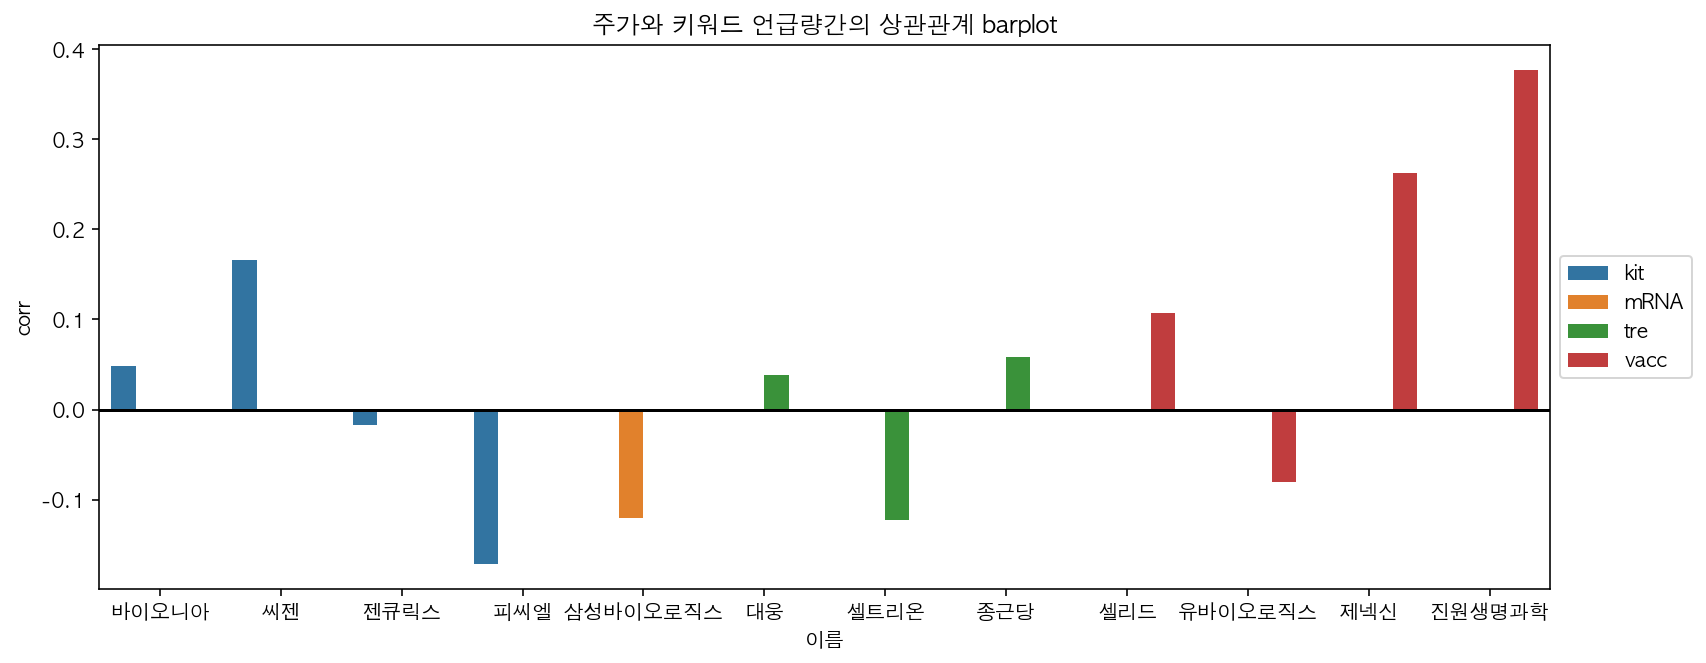

In [74]:
#seaborn으로 할 경우 bar 과 xticks 간의 alignment가 맞지 않음
#따라서 위의 matplotlib 방식으로 진행함
plt.subplots(figsize=(13,5))
sns.barplot(x = '이름', y='corr', data=corr_df, hue = '분야')
plt.axhline(y=0, color='black', linestyle='-')
plt.title('주가와 키워드 언급량간의 상관관계 barplot')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 주식간의 상관관계 구하기

In [75]:
total_df.head()

,이름,일자,종가,scale_종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,분야
0,젠큐릭스,2021/05/18,21950,0.773029,250,1.15,21800,22100,21250,62618,1352238100,141951484100,6467038,kit
1,젠큐릭스,2021/05/17,21700,0.707258,-750,-3.34,22500,22600,21450,89390,1959916250,140334724600,6467038,kit
2,젠큐릭스,2021/05/14,22450,0.904572,150,0.67,22500,22650,21700,75327,1671565450,145185003100,6467038,kit
3,젠큐릭스,2021/05/13,22300,0.865109,-1050,-4.50,22650,23650,21950,120638,2741481300,144214947400,6467038,kit
4,젠큐릭스,2021/05/12,23350,1.141348,-350,-1.48,23550,24100,22450,220544,5156506500,151005337300,6467038,kit


In [76]:
df3 = total_df.pivot(columns ='이름',values='scale_종가', index='일자')

In [77]:
df3.corr()

이름,대웅,바이오니아,삼성바이오로직스,셀리드,셀트리온,씨젠,유바이오로직스,제넥신,젠큐릭스,종근당,진원생명과학,피씨엘
이름,,,,,,,,,,,,
대웅,1.000000,-0.367605,-0.426935,0.278141,-0.148448,-0.500736,-0.180576,-0.210812,0.435063,-0.087161,-0.383736,-0.223438
바이오니아,-0.367605,1.000000,0.803868,0.468276,0.771567,0.940898,0.781535,0.919485,0.123245,0.846476,0.889714,0.672857
삼성바이오로직스,-0.426935,0.803868,1.000000,0.396172,0.898643,0.843148,0.767706,0.769822,0.020208,0.816525,0.768860,0.752441
셀리드,0.278141,0.468276,0.396172,1.000000,0.442296,0.301938,0.690955,0.534117,0.566366,0.444343,0.444849,0.681241
셀트리온,-0.148448,0.771567,0.898643,0.442296,1.000000,0.791251,0.700694,0.798421,0.119957,0.880429,0.710234,0.660973
씨젠,-0.500736,0.940898,0.843148,0.301938,0.791251,1.000000,0.679813,0.870937,-0.035974,0.823013,0.863498,0.596804
유바이오로직스,-0.180576,0.781535,0.767706,0.690955,0.700694,0.679813,1.000000,0.728569,0.080458,0.742729,0.710596,0.873324
제넥신,-0.210812,0.919485,0.769822,0.534117,0.798421,0.870937,0.728569,1.000000,0.255560,0.839134,0.849936,0.577071
젠큐릭스,0.435063,0.123245,0.020208,0.566366,0.119957,-0.035974,0.080458,0.255560,1.000000,0.080072,0.056988,0.085150


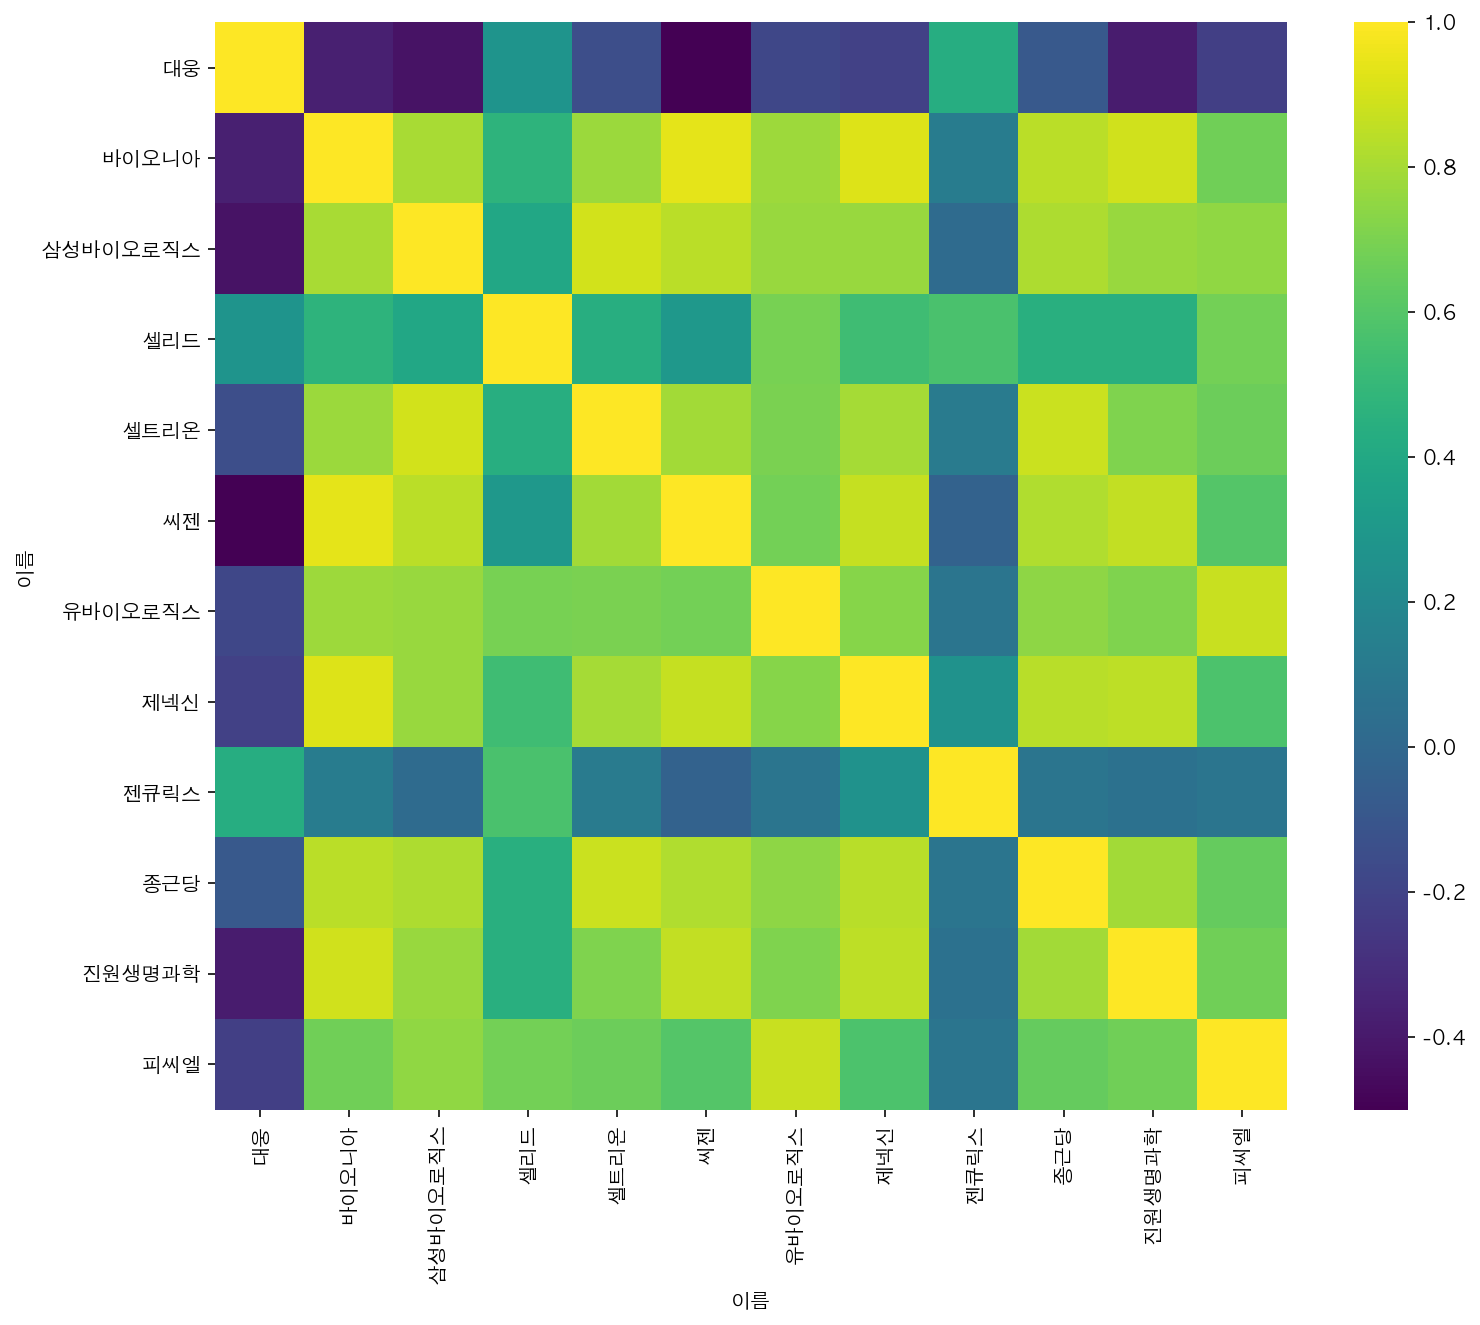

In [78]:
plt.subplots(figsize=(12,10))
sns.heatmap(df3.corr(), cmap = 'viridis')
plt.show()

- 12개의 백신관련 주식 중 대부분이 높은 양의 상관관계를 가지고 있으나, 젠큐릭스와 대웅, 셀리드 이 세개의 주가는 다른 주식들과 낮은 음의 상관관계 (대웅의 경우 높은 음의 상관관계)를 가지는 것을 발견할 수 있었다.
- 또한 이 세개의 주식(젠큐릭스, 대웅, 셀리드) 간에는 0.4 정도의 양의 상관관계가 있음을 확인 할 수 있다.

- 대웅의 경우, 3차 대유행 초기에 상승과 갑작스러운 하락을 거쳤으며, 그 낙폭이 매우 크다. 
- 코로나 대유행 시기 동안, 대부분의 주식은 초기 시작점보다 상승하였으나, 젠큐릭스와 대웅은 상승후 큰 하락세가 이어졌다. 이를 통해 두 주식간의 양의 상관관계를 갖게 된 것으로 보인다.
- **코로나 대 유행 시기에 거의 유일하게 하락한 대웅과 젠큐릭스가 둘 간의 상관관계가 높다는 것이 흥미롭다.** 


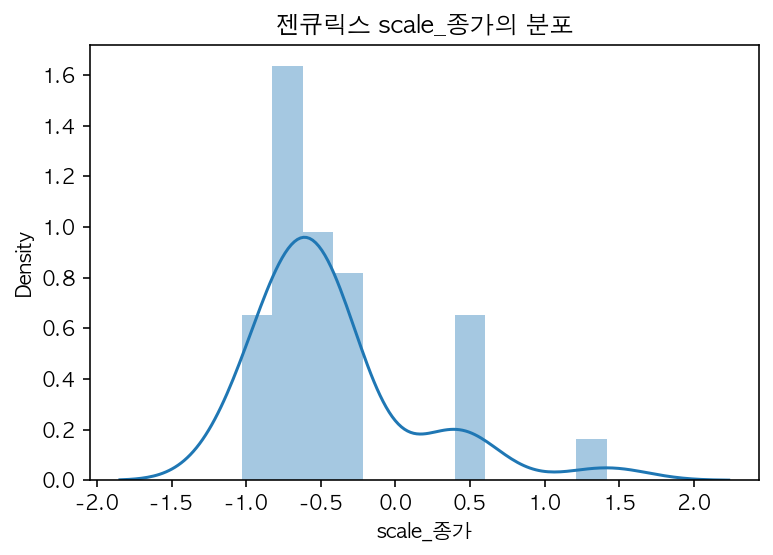

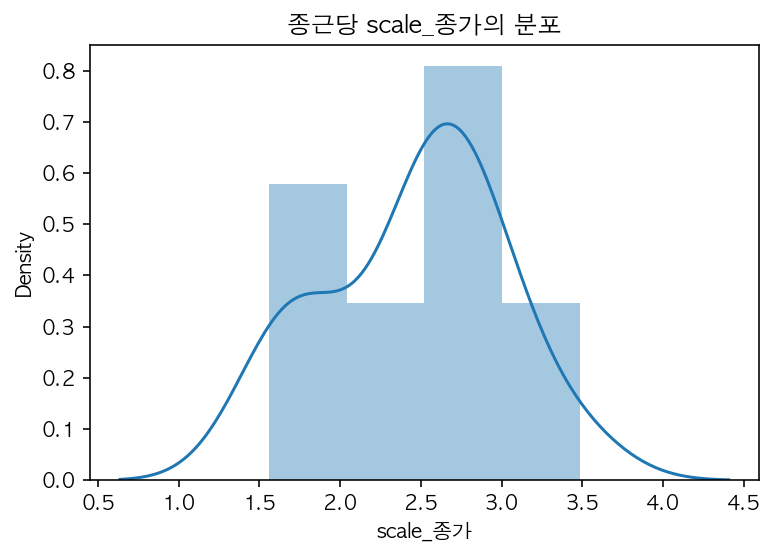

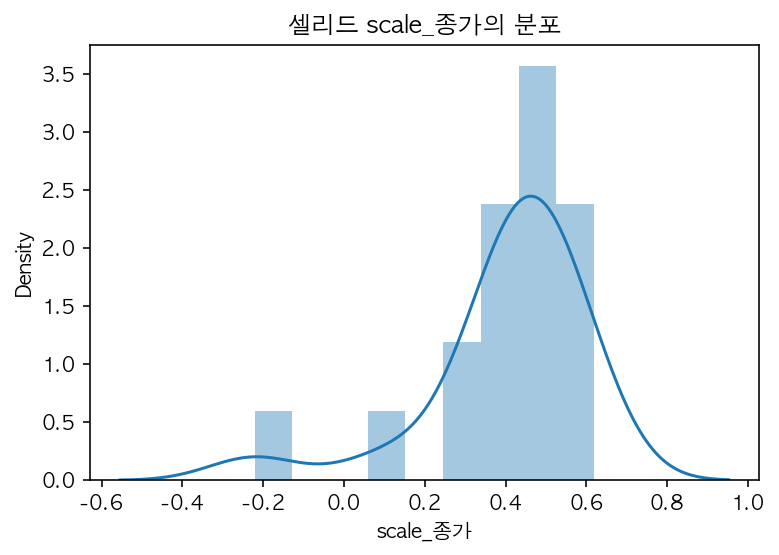

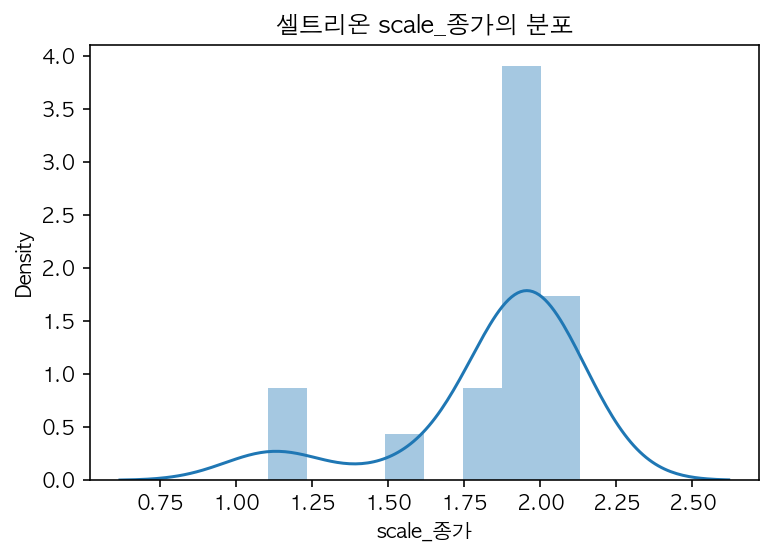

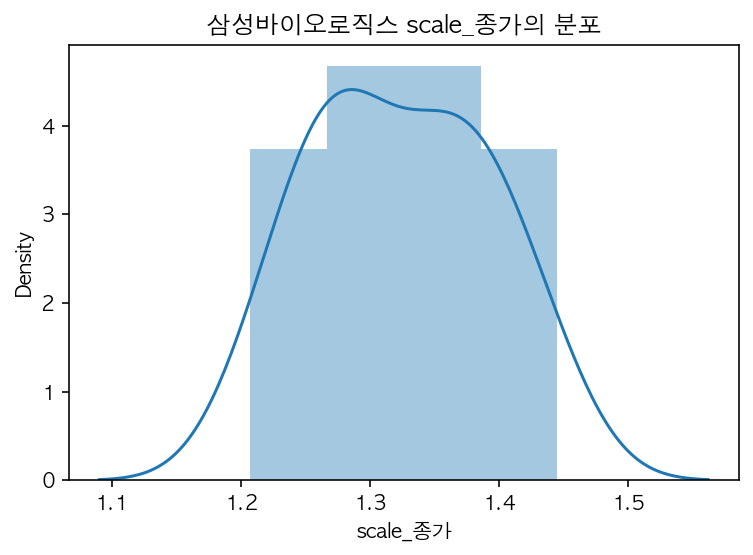

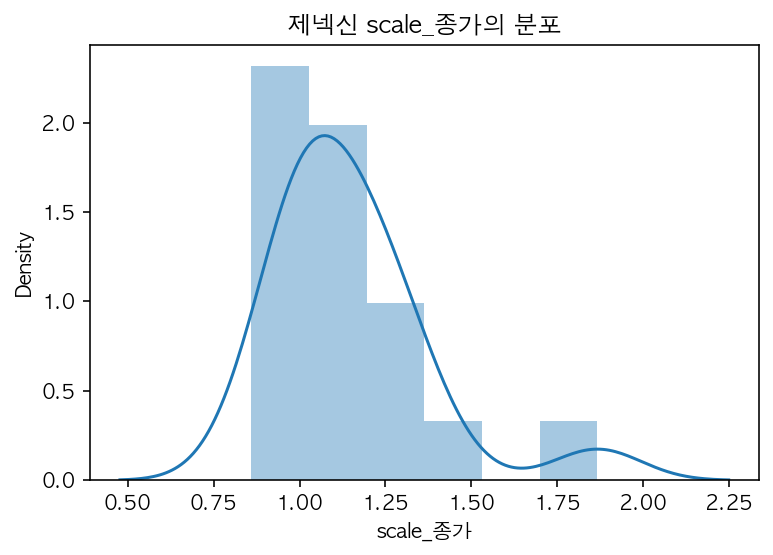

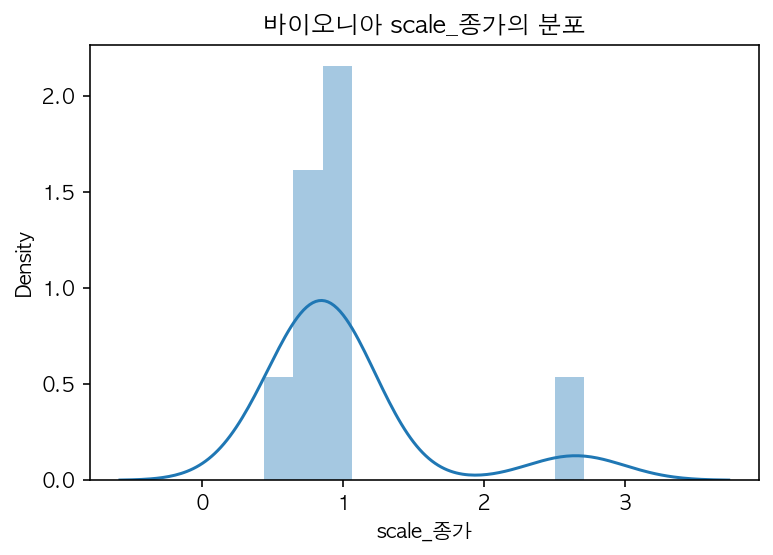

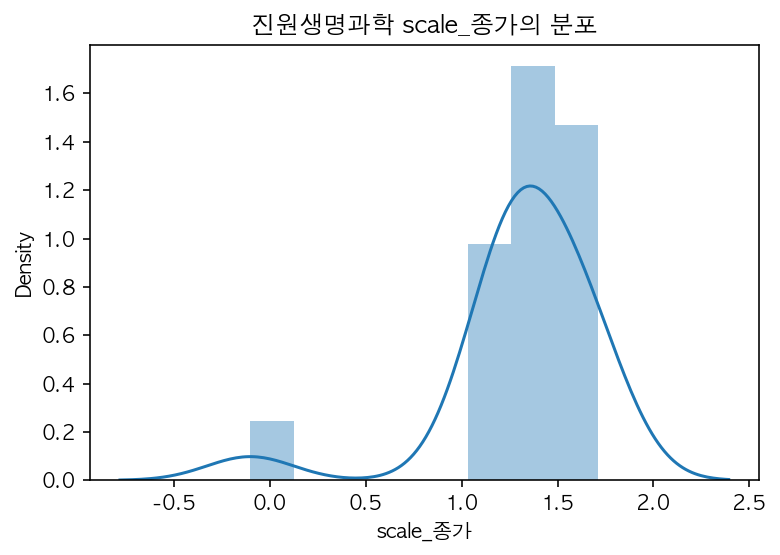

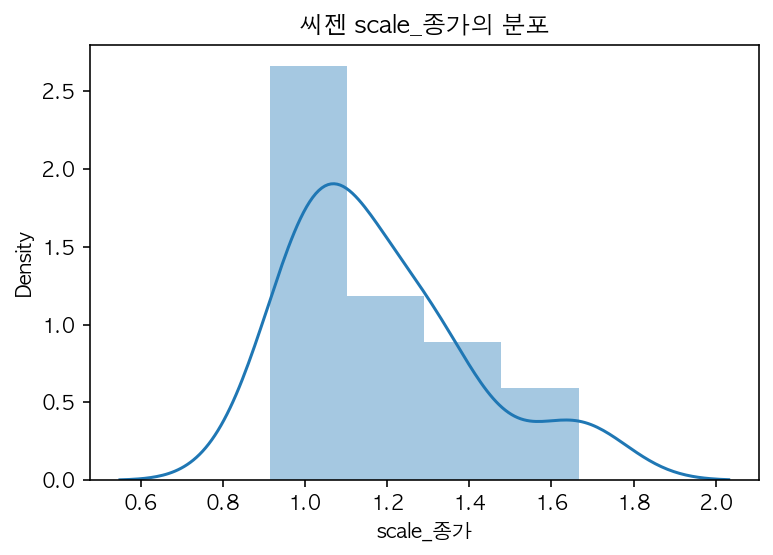

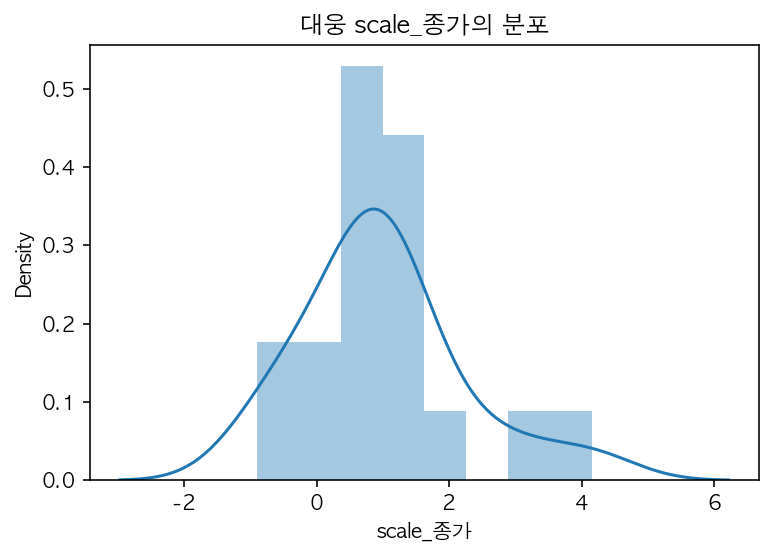

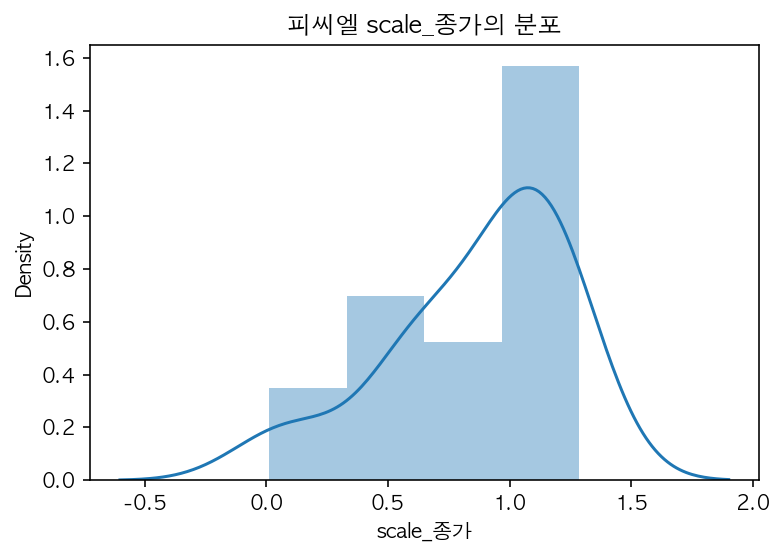

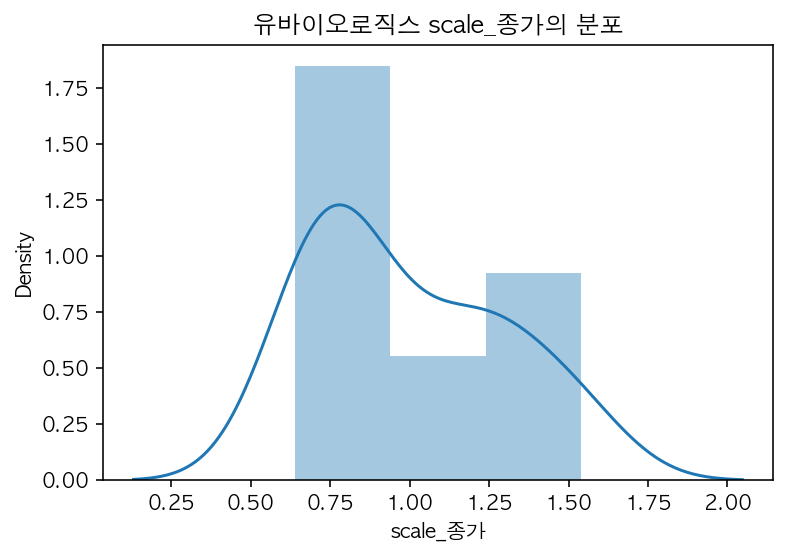

In [79]:
for c in company:
    sns.distplot(df2[df2['이름']==c]['scale_종가'])
    plt.title(f'{c} scale_종가의 분포')
    plt.show()

### 분야별 주식간의 상관관계

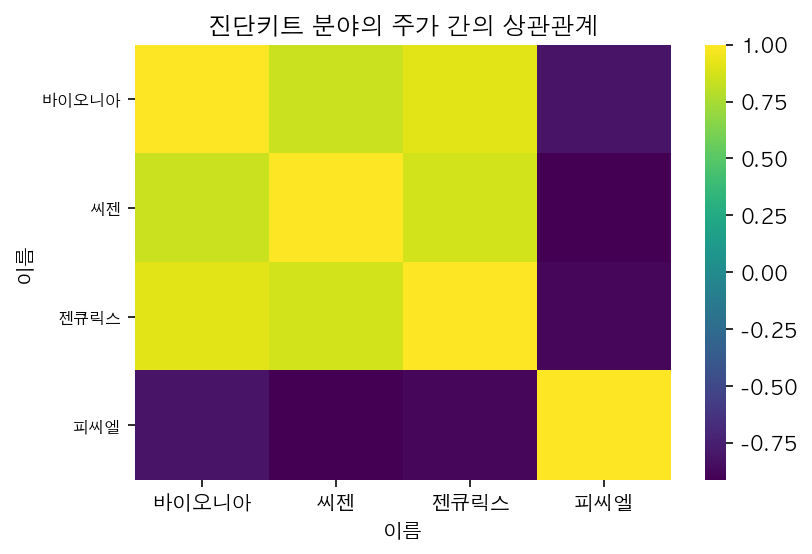

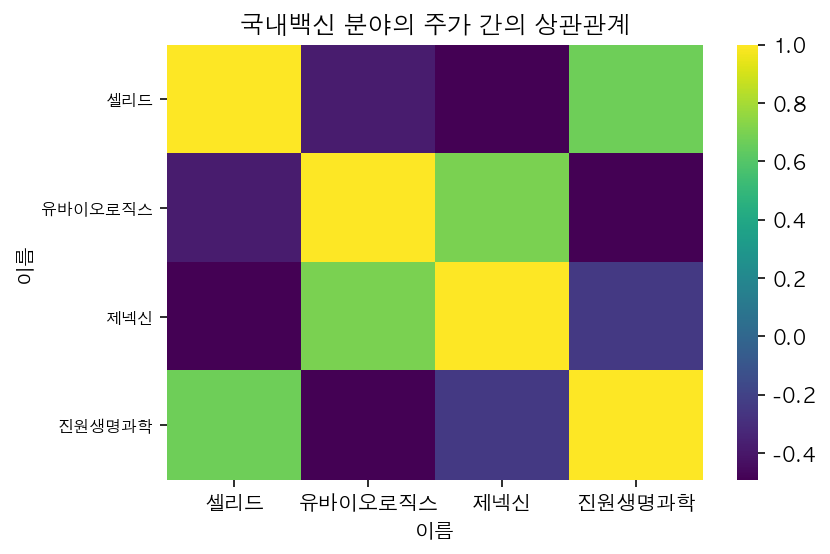

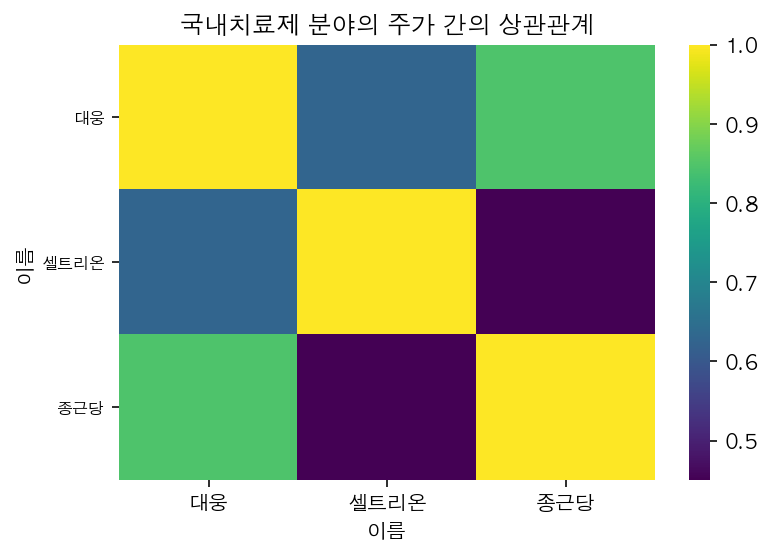

In [80]:
for i, key in enumerate(category.keys()):
    if i>0:
        temp_df = df2[df2['분야']==key].pivot(columns ='이름',values='scale_종가', index='일자')
        g = sns.heatmap(temp_df.corr(), cmap = 'viridis')
        g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
        plt.title(f'{title_name[i]} 분야의 주가 간의 상관관계')
        plt.show()
      

- 같은 분야 내의 주가간의 상관관계를 살펴보았을 때, 진단키트는 4개 중 3개가 높은 양의 상관관계를 보임
- 치료제 분야에서는 3개의 주식이 모두 비슷하게 높은 양의 상관관계를 보임